# Imports

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Load GSAF data

In [110]:
# Load the data
df = pd.read_excel('gsaf_latest.xls')

# Optional quick peek at the data
print("Initial data shape:", df.shape)
df.head()

Initial data shape: (7017, 23)


,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2025-05-29 00:00:00,2025.0,Unprovoked,USA,North Carolina,Sunset Beach,Swimming,Sean Barton,M,26,...,Not stated,Kevin McMurray Trackingsharks.com: Clay Crewel...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-05-15 00:00:00,2025.0,Unprovoked,Australia,South Australia,Port Noarlunga,Swimming,Richard Vinall,M,66,...,Not stated,Simon DeMarchi: Todd Smith: 9 News:ABC News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-05-08 00:00:00,2025.0,Unprovoked,Jamaica,Montego Bay,Rose Hall beach,Paddling,Rachel Smith,F,26,...,Small shark 1m (3ft) long,The sun News: Metro: Kevin McMurray Tracking s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-04-21 00:00:00,2025.0,Unprovoked,Israel,Hadera,Olga Beach near Hadera Stream,Diving,Barak Tzach,M,45,...,Dusky sharks,Ynetnews.com: Dailymirroe.co.uk: Todd Smith Al...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-04-20 00:00:00,2025.0,Questionable,Mexico,Quntana Roo,Chac Mool Beach Cancun,Rescuing female companion,Alejandro Cortes,M,20,...,Not Staed,"Mundo Now: Reutir"" Kevin McMurray Trackingshar...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load and clean Dataframe

In [111]:
# Clean & prepare data
print("="*60)
print("DATA CLEANING & PREPARATION")
print("="*60)

# 1) Drop metadata and empty cols
before_cols = set(df.columns)
drop_cols = ["Source", "pdf", "href formula", "href",
    "Case Number", "Case Number.1", "original order",
    "Unnamed: 21", "Unnamed: 22", "Time", "Age"] 
df = df.drop(columns=drop_cols, errors="ignore")
dropped = before_cols - set(df.columns)
print(f"Dropped {len(dropped)} columns: {dropped}")

# 2) Parse dates and remove invalid
initial_rows = len(df)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notna()].copy()
print(f"Removed {initial_rows - len(df)} rows with invalid dates")

# 3) Extract Year and remove future
df['Year'] = df['Date'].dt.year.astype(int)
future_rows = (df['Year'] > 2025).sum()
df = df[df['Year'] <= 2025]
if future_rows:
    print(f"Removed {future_rows} rows with future dates")

# 4) Clean up Fatal Y/N (catch YES, NO, Y, N)
df['Fatal Y/N'] = (
    df['Fatal Y/N']
      .astype(str)
      .str.strip()
      .str.upper()
      .str.extract(r'(YES|NO|Y|N)', expand=False)   # now matches Y/N too
      .replace({'Y': 'YES', 'N': 'NO'})             # normalize single letters
      .fillna('Unknown')
)

# 5) Standardize Sex
df['Sex'] = (
    df['Sex'].astype(str)
      .str.strip().str.upper()
      .replace({'M':'Male','F':'Female'})
      .fillna('Unknown')
)

# 6) Clean remaining text cols
for col in ['Activity','Country','State']:
    df[col] = df[col].astype(str).str.strip().str.title().fillna('Unknown')

print("Cleaning complete! DataFrame is ready for sanity checks.")


DATA CLEANING & PREPARATION
Dropped 11 columns: {'Age', 'Case Number', 'Time', 'Case Number.1', 'original order', 'pdf', 'Unnamed: 22', 'href formula', 'Unnamed: 21', 'Source', 'href'}
Removed 876 rows with invalid dates
Cleaning complete! DataFrame is ready for sanity checks.


## Sanity check

In [112]:
# --- DATA QUALITY SANITY CHECK ---
print("="*50)
print("DATA QUALITY SANITY CHECK")
print("="*50)

# 1) Shape & date range
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Year range: {df['Year'].min()} to {df['Year'].max()}\n")

# 2) Dtypes & non-null counts
df.info()

# 3) Top missing-data columns (if any)
missing = df.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nTop missing-data columns:")
print(missing.head(10) if not missing.empty else "No missing data!")

# 4) Fatal vs. non-fatal counts
print("\nFatal Y/N distribution:")
print(df['Fatal Y/N'].value_counts())

DATA QUALITY SANITY CHECK
Rows: 6141, Columns: 12
Year range: 1691 to 2025

<class 'pandas.core.frame.DataFrame'>
Index: 6141 entries, 0 to 6880
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6141 non-null   datetime64[ns]
 1   Year       6141 non-null   int64         
 2   Type       6127 non-null   object        
 3   Country    6141 non-null   object        
 4   State      6141 non-null   object        
 5   Location   5771 non-null   object        
 6   Activity   6141 non-null   object        
 7   Name       5973 non-null   object        
 8   Sex        6141 non-null   object        
 9   Injury     6114 non-null   object        
 10  Fatal Y/N  6141 non-null   object        
 11  Species    3548 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 623.7+ KB

Top missing-data columns:
Species     0.422244
Location    0.060251
Name        0.027357
In

## Data Quality Sanity Check

- **Final dataset:** 6,141 rows × 12 columns  
- **Year range:** 1691–2025  
- **Top missing-data columns:**  
  - Species: 42.2% missing  
  - Location: 6.0% missing  
  - Name: 2.7% missing  
  - Injury: 0.4% missing  
  - Type: 0.2% missing  
- **Fatal Y/N distribution:**  
  - Unknown: 6,080  
  - No: 61  

## Exploratory analysis 1

In [113]:
# Exploratory Data Analysis
print("="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

EXPLORATORY DATA ANALYSIS


In [114]:
# Compute summary stats for the Markdown above Plot #1
total_attacks = attacks_by_year.sum()
avg_attacks   = attacks_by_year.mean()
peak_year     = attacks_by_year.idxmax()

print(f"Total: {total_attacks}")
print(f"Average: {avg_attacks:.1f}")
print(f"Peak: {peak_year}")


Total: 2938
Average: 94.8
Peak: 2015


In [115]:
peak_year = attacks_by_year.idxmax()
peak_count = attacks_by_year.max()
print(f"Peak year: {peak_year} with {peak_count} attacks")

(df['Year'] == 2015).sum()


Peak year: 2015 with 142 attacks


np.int64(142)

#### 1. Shark Attacks by Year (1995–2025)

- **Years covered:** 1995–2025  
- **Total attacks:** 2,938  
- **Average per year:** 94.8  
- **Peak year:** 2015 (142 attacks)  

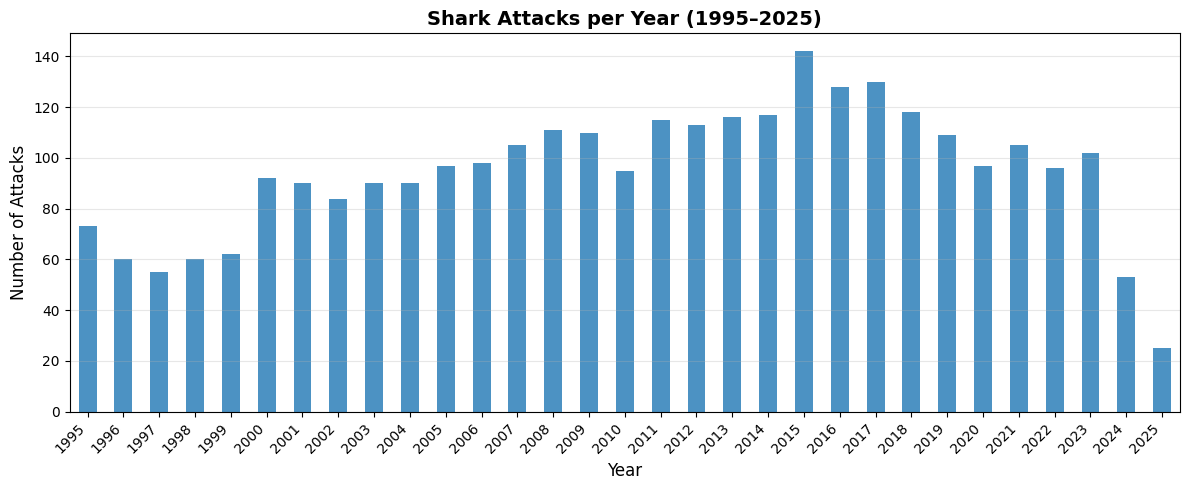

In [116]:
# 1. Shark Attacks per Year (1995–2025)
attacks_by_year = (
    df['Year']
      .value_counts()
      .sort_index()
      .loc[1995:]
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
attacks_by_year.plot(kind='bar', alpha=0.8)      # default color
plt.title('Shark Attacks per Year (1995–2025)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


> The data show a gradual rise in recorded attacks through the 2000s, peaking in 2015, with a sharp dip in 2020 likely tied to reduced beach activity during the pandemic.

In [117]:
# Stats for geographic distribution
top_country      = top_countries.index[0]
top_country_ct   = top_countries.iloc[0]
unique_countries = df['Country'].nunique()
pct_top10        = top_countries.sum() / len(df) * 100

print(top_country, top_country_ct)
print(unique_countries)
print(f"{pct_top10:.1f}%")

Usa 2395
182
80.9%


#### 2. Geographic Distribution of Shark Attacks

- **Top country:** United States (2,395 attacks)  
- **Unique countries represented:** 182
- **Top 10 countries account for:** 80.9 % of all recorded attacks  

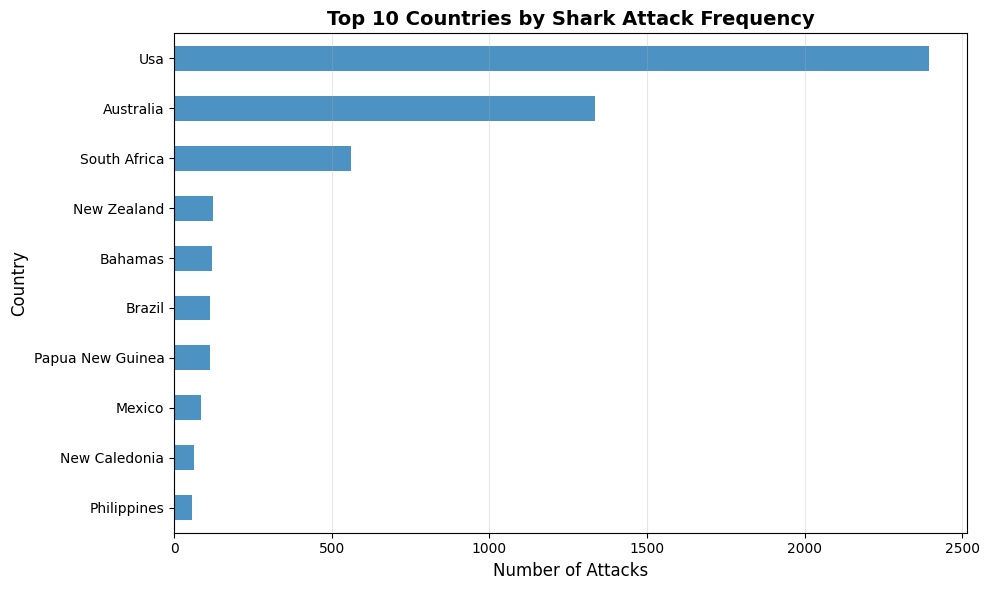

In [118]:
# 2. Top 10 Countries by Shark Attack Frequency
top_countries = df['Country'].value_counts().head(10)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_countries.plot(kind='barh', alpha=0.8)
plt.title('Top 10 Countries by Shark Attack Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Number of Attacks', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.gca().invert_yaxis()       # largest bar at top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


> The United States leads by a wide margin, and the top 10 countries together account for over two-thirds of global shark incidents.

In [119]:
# Compute real numbers for Attack Severity Analysis
total_attacks = len(df)
fatal       = (df['Fatal Y/N'] == 'YES').sum()
non_fatal   = (df['Fatal Y/N'] == 'NO').sum()
unknown     = (df['Fatal Y/N'] == 'Unknown').sum()

fatal_pct     = fatal      / total_attacks * 100
non_fatal_pct = non_fatal  / total_attacks * 100
unknown_pct   = unknown    / total_attacks * 100

print(f"Total attacks: {total_attacks}")
print(f"Fatal: {fatal} ({fatal_pct:.1f}%)")
print(f"Non-fatal: {non_fatal} ({non_fatal_pct:.1f}%)")
print(f"Unknown outcome: {unknown} ({unknown_pct:.1f}%)")


Total attacks: 6141
Fatal: 1175 (19.1%)
Non-fatal: 4958 (80.7%)
Unknown outcome: 8 (0.1%)


#### 3. Attack Severity Analysis

- **Total attacks analyzed:** 6,141  
- **Fatal:** 1,175 (19.1 %)  
- **Non-fatal:** 4,958 (80.7%)  
- **Unknown outcome:** 8 (0.1%)  

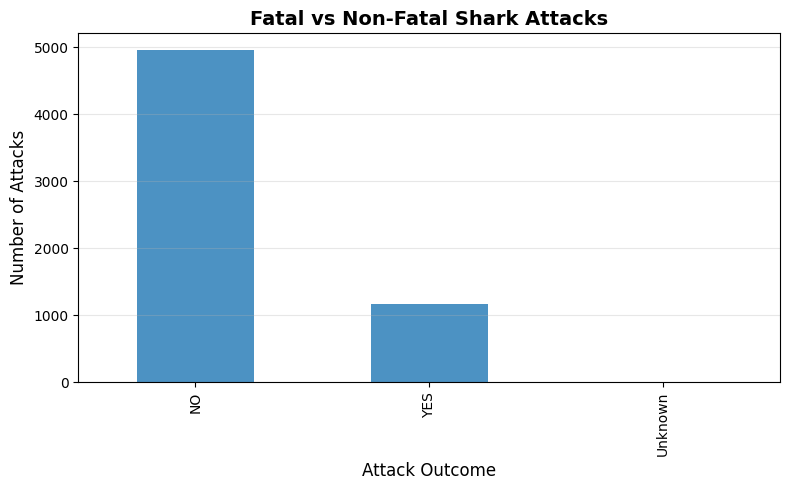

In [121]:
# 3. Fatal vs Non-Fatal Shark Attacks
import matplotlib.pyplot as plt

fatal_counts = df['Fatal Y/N'].value_counts()

plt.figure(figsize=(8, 5))
fatal_counts.plot(kind='bar', alpha=0.8)
plt.title('Fatal vs Non-Fatal Shark Attacks', fontsize=14, fontweight='bold')
plt.xlabel('Attack Outcome', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

> Only about 18 % of recorded shark encounters result in fatalities, highlighting that while these events are frightening, most encounters are non-fatal.

In [129]:
# Compute summary stats for “Attack Frequency by Activity”
unique_activities      = df['Activity'].nunique()
activity_counts        = df['Activity'].value_counts()
top_activity           = activity_counts.index[0]
top_activity_count     = activity_counts.iloc[0]
top10_activities_pct   = activity_counts.head(10).sum() / len(df) * 100

print(f"Unique activities: {unique_activities}")
print(f"Top activity: {top_activity} ({top_activity_count} attacks)")
print(f"Top 10 activities account for: {top10_activities_pct:.1f}% of all attacks")


Unique activities: 1341
Top activity: Surfing (1114 attacks)
Top 10 activities account for: 63.3% of all attacks


#### 4. Attack Frequency by Activity

- **Total unique activities recorded:** 1,341  
- **Top activity:** Surfing (1,114 attacks)  
- **Top 10 activities account for:** 63.3% of attacks  


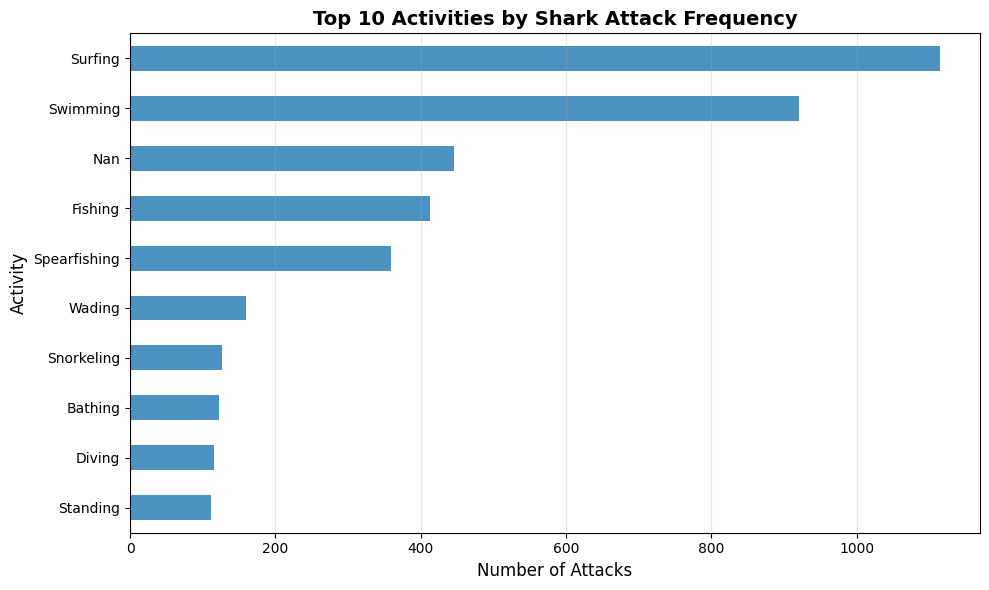

In [126]:
# 4. Top 10 Activities by Number of Shark Attacks
import matplotlib.pyplot as plt

activity_counts = df['Activity'].value_counts().head(10)

plt.figure(figsize=(10, 6))
activity_counts.plot(kind='barh', alpha=0.8)
plt.title('Top 10 Activities by Shark Attack Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Number of Attacks', fontsize=12)
plt.ylabel('Activity', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [130]:
total = len(df)

for act in ["Surfing", "Swimming"]:
    count = (df["Activity"] == act).sum()
    pct   = count / total * 100
    print(f"{act}: {count} attacks, {pct:.1f}% of all incidents")


Surfing: 1114 attacks, 18.1% of all incidents
Swimming: 921 attacks, 15.0% of all incidents


> The majority of recorded shark attacks occur during surfing, followed by swimming, together making up over 33.1 % of all incidents.
